# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [27]:
import pandas as pd
import zipfile

raw_df = pd.read_csv('/content/tweet_sentiment_train.csv.zip')
raw_df[:5]

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [28]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [29]:
raw_df_cleaned = raw_df.dropna()
raw_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [30]:
raw_df_cleaned.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


Маємо три класи. Найбільш представлений клас neutral.


<ipython-input-31-722f740fa75f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_cleaned['text_length'] = raw_df_cleaned['text'].apply(len)
<ipython-input-31-722f740fa75f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_cleaned['selected_text_length'] = raw_df_cleaned['selected_text'].apply(len)


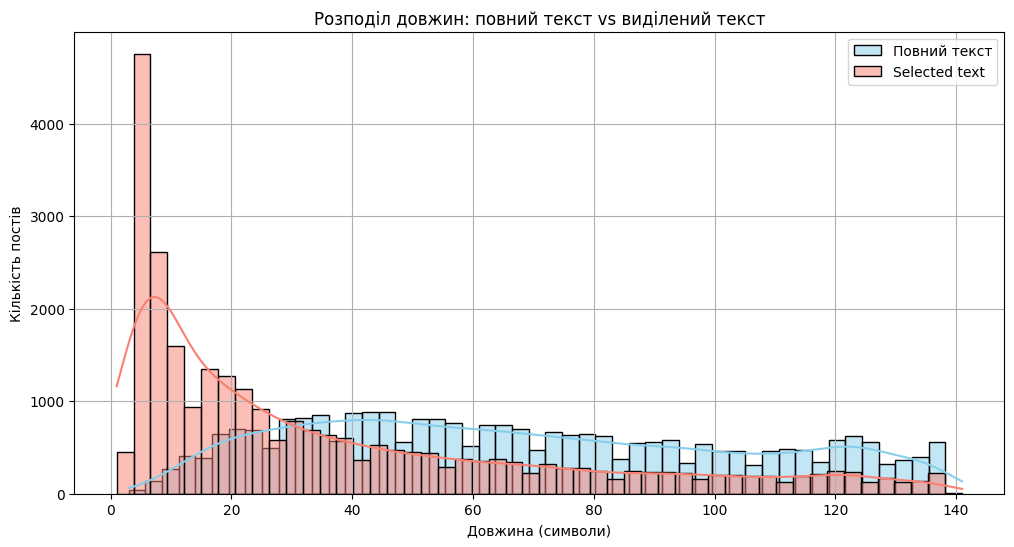

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

raw_df_cleaned['text_length'] = raw_df_cleaned['text'].apply(len)
raw_df_cleaned['selected_text_length'] = raw_df_cleaned['selected_text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(raw_df_cleaned['text_length'], bins=50, color='skyblue', label='Повний текст', kde=True)
sns.histplot(raw_df_cleaned['selected_text_length'], bins=50, color='salmon', label='Selected text', kde=True)
plt.title("Розподіл довжин: повний текст vs виділений текст")
plt.xlabel("Довжина (символи)")
plt.ylabel("Кількість постів")
plt.legend()
plt.grid(True)
plt.show()



Спостерігаємо нерівномірні розподіли. Бачимо що вибраний текст має набагато менше символів. Колонка тест може містити ціле речення, в той час як вибраний текст має декілька слів.

### Завдання 3. Попередня обробка текстових даних та

---

векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [48]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Завантаження ресурсів
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    text = text.lower()  # нижній регістр
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # прибрати URL
    text = re.sub(r"[^a-zA-Z\s]", '', text)  # прибрати все, крім літер
    text = re.sub(r"\s+", ' ', text).strip()  # прибрати зайві пробіли

    # Токенізація
    tokens = word_tokenize(text)

    # Видалення стоп-слів і стеммінг
    cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return " ".join(cleaned)

raw_df_cleaned['clean_text'] = raw_df_cleaned['text'].apply(preprocess_text)

vectorizer = CountVectorizer(max_features=10000)
X_bow = vectorizer.fit_transform(raw_df_cleaned['clean_text'])

print("Розмірність матриці (n_docs × n_words):", X_bow.shape)
print("Перші 10 слів у словнику:", vectorizer.get_feature_names_out()[:10])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-48-fe98aa7d9eda>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_cleaned['clean_text'] = raw_df_cleaned['text'].apply(preprocess_text)


Розмірність матриці (n_docs × n_words): (27480, 10000)
Перші 10 слів у словнику: ['aaaa' 'aaaaaa' 'aaaaaaaaaaa' 'aaaaaaaaaahhhhhhhh' 'aaaaaaaaaamaz'
 'aaaaaaaafternoon' 'aaaaaaaahhhhhhhh' 'aaaaaah' 'aaaaaahhhhhhhh'
 'aaaaaalcohol']


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?




🔹 Навчання моделі: Logistic Regression
Точність (Accuracy): 0.6889
Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.67      0.69      0.68      1556
     neutral       0.66      0.66      0.66      2223
    positive       0.75      0.73      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.69      0.69      0.69      5496
weighted avg       0.69      0.69      0.69      5496



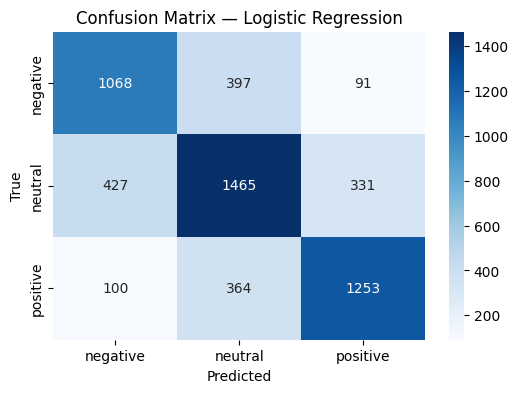


🔹 Навчання моделі: Decision Tree
Точність (Accuracy): 0.6441
Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.62      0.63      0.62      1556
     neutral       0.63      0.61      0.62      2223
    positive       0.69      0.71      0.70      1717

    accuracy                           0.64      5496
   macro avg       0.64      0.65      0.65      5496
weighted avg       0.64      0.64      0.64      5496



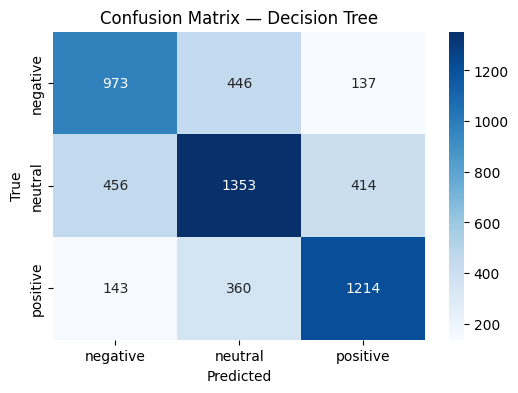


🔹 Навчання моделі: Random Forest
Точність (Accuracy): 0.6932
Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.71      0.62      0.66      1556
     neutral       0.65      0.71      0.68      2223
    positive       0.74      0.74      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496



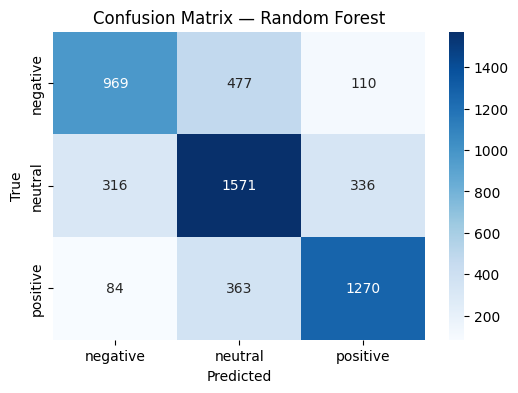

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


y = raw_df_cleaned['sentiment']

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced')
}

for name, model in models.items():
    print(f"\n🔹 Навчання моделі: {name}")
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)

    acc = accuracy_score(y_test, y_pred)
    print(f"Точність (Accuracy): {acc:.4f}")
    print("Звіт класифікації:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [34]:
pip install lightgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 21984, number of used features: 1062
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔍 Точність (accuracy): 0.7061
📊 Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.71      0.65      0.68      1556
     neutral       0.66      0.71      0.69      2223
    positive       0.76      0.75      0.75      1717

    accuracy                           0.71      5496
   macro avg       0.71      0.70      0.71      5496
weighted avg       0.71      0.71      0.71      5496



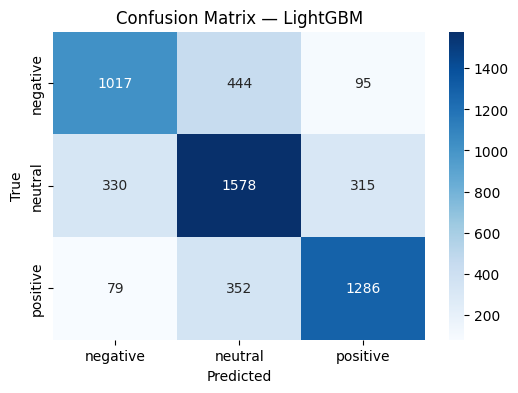

In [50]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_train_bow = X_train_bow.astype(np.float32)
X_test_bow = X_test_bow.astype(np.float32)

lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_train_bow, y_train)

y_pred_lgbm = lgbm_model.predict(X_test_bow)

acc = accuracy_score(y_test, y_pred_lgbm)
print(f"🔍 Точність (accuracy): {acc:.4f}")
print("📊 Звіт класифікації:")
print(classification_report(y_test, y_pred_lgbm))

cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lgbm_model.classes_, yticklabels=lgbm_model.classes_)
plt.title("Confusion Matrix — LightGBM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Найкраще покаказали себе моделі Logistic Regression та LGBMClassifier. За основну метрику вибрала f1 score на найменш представленому класі. Загалом можна сказати, що модель показала хороші результати.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


       token  importance
6109    love         107
6424    miss         101
8886   thank          89
3164    good          87
7904     sad          87
4324    hope          80
448   awesom          72
8400   sorri          71
1991    dont          69
3353   great          67
8654    suck          65
6701    nice          63
3738   happi          63
4701      im          61
3804    hate          61
2930     get          60
808     bore          58
488      bad          58
3040    glad          58
219     amaz          57


<ipython-input-51-45eb6b4102b2>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='token', palette='viridis')


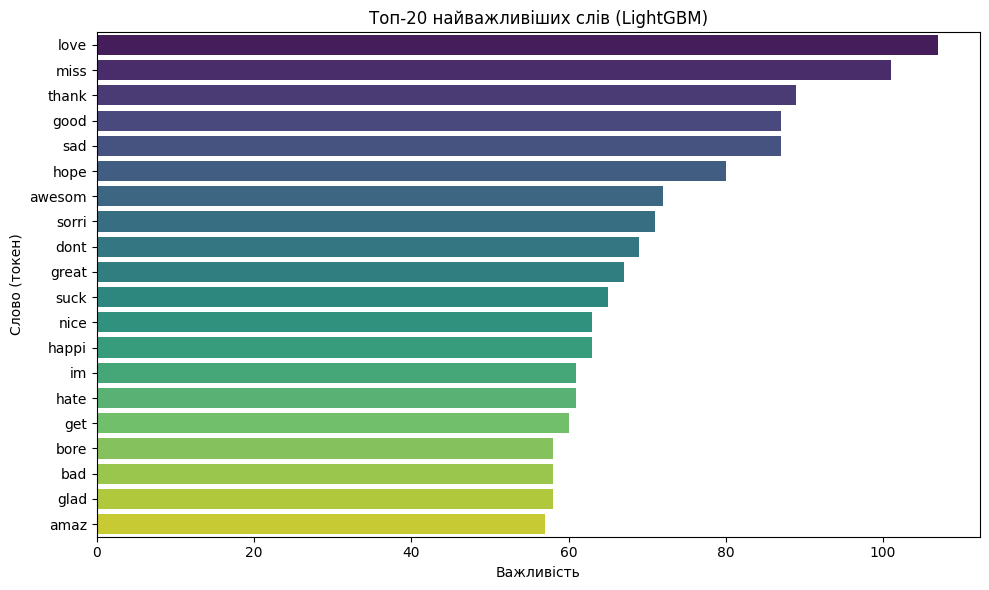

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = vectorizer.get_feature_names_out()
importances = lgbm_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'token': feature_names,
    'importance': importances
})

top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

print(top_features)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='token', palette='viridis')
plt.title('Топ-20 найважливіших слів (LightGBM)')
plt.xlabel('Важливість')
plt.ylabel('Слово (токен)')
plt.tight_layout()
plt.show()


Найбільш важливими словами hope, love, like, miss тощо. Це виглядає доволі логічно, оскільки ці слова мають емоційне забарвлення.


### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



<ipython-input-52-fea601ee388c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_cleaned['clean_text'] = raw_df_cleaned['text'].apply(preprocess_text)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36451
[LightGBM] [Info] Number of data points in the train set: 21984, number of used features: 1062
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔍 Точність (accuracy): 0.7023
📊 Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.71      0.65      0.68      1556
     neutral       0.66      0.71      0.68      2223
    positive       0.76      0.74      0.75      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.70      0.70      5496
weighted avg       0.70      0.70      0.70      5496



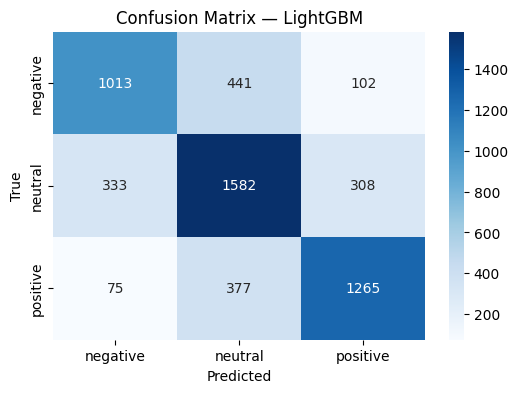

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

raw_df_cleaned['clean_text'] = raw_df_cleaned['text'].apply(preprocess_text)

vectorizer_tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer_tfidf.fit_transform(raw_df_cleaned['clean_text'])

y = raw_df_cleaned['sentiment']
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

X_train_tfidf = X_train_tfidf.astype(np.float32)
X_test_tfidf = X_test_tfidf.astype(np.float32)

lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_train_tfidf, y_train)

y_pred_lgbm = lgbm_model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred_lgbm)
print(f"🔍 Точність (accuracy): {acc:.4f}")
print("📊 Звіт класифікації:")
print(classification_report(y_test, y_pred_lgbm))

cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lgbm_model.classes_, yticklabels=lgbm_model.classes_)
plt.title("Confusion Matrix — LightGBM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



       token  importance
6109    love         107
3164    good         105
8886   thank          95
6424    miss          95
4324    hope          85
8654    suck          81
3738   happi          79
8400   sorri          78
3353   great          78
7904     sad          78
6701    nice          77
448   awesom          72
808     bore          71
652   better          70
488      bad          69
3804    hate          67
2227   enjoy          66
4529    hurt          63
3040    glad          62
1032    cant          61


<ipython-input-53-787ba5d58e68>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='token', palette='viridis')


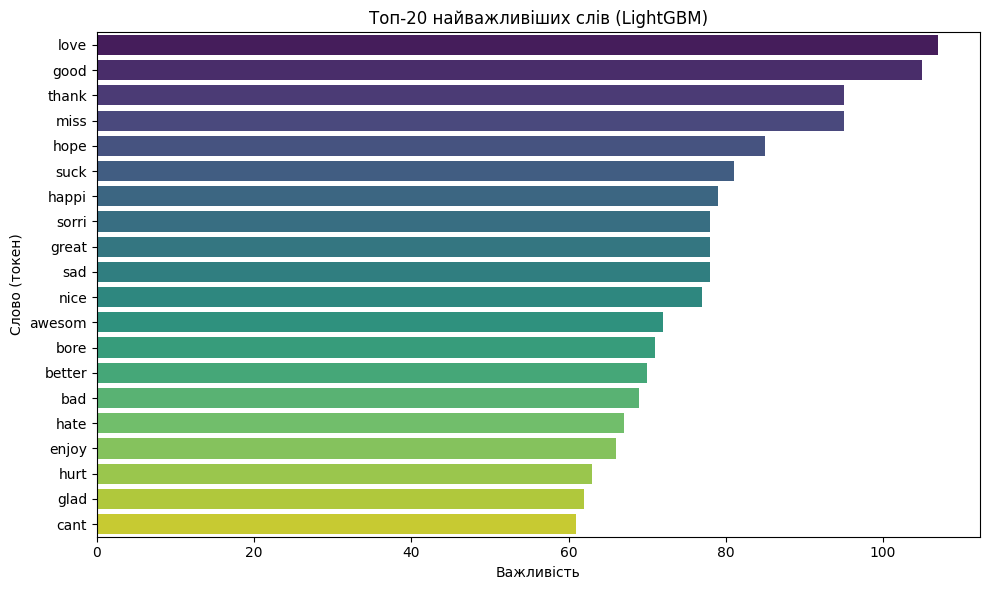

In [53]:
feature_names = vectorizer_tfidf.get_feature_names_out()
importances = lgbm_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'token': feature_names,
    'importance': importances
})

top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

print(top_features)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='token', palette='viridis')
plt.title('Топ-20 найважливіших слів (LightGBM)')
plt.xlabel('Важливість')
plt.ylabel('Слово (токен)')
plt.tight_layout()
plt.show()

Результати моделі після векторизації шляхом TF-IDF подібні до результатів після BoW. Важливі слова також доволі схожі і теж мають емоційне забарвлення.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [54]:
import numpy as np

mistakes_indices = np.where(y_test != y_pred_lgbm)[0]

mistakes_df = X_test_df.iloc[mistakes_indices]

mistakes_df['actual'] = y_test.iloc[mistakes_indices].values
mistakes_df['predicted'] = y_pred_lgbm[mistakes_indices]

pd.set_option('display.max_colwidth', None)
print(mistakes_df[['text', 'actual', 'predicted']].head(20))


                                                                                                                               text  \
23415                                                    arnold, california.  aka the best place ever...wish you could come with!!!   
24610                                                   hey Nat, just wondering, why are your videos never available on the iPhone?   
4128                                                                         omg! I dont blame you! hope you didnt hurt him too bad   
20628                                                                                                            I am following Mya   
19361                                                                                 So booooored  I learned this though! ????????   
10653                                 Brand new is playing at the epicenter in July when I`m in NY. Jesse lacey why do you hate me?   
17485                                                  

<ipython-input-54-d1ddc25faa02>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistakes_df['actual'] = y_test.iloc[mistakes_indices].values
<ipython-input-54-d1ddc25faa02>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistakes_df['predicted'] = y_pred_lgbm[mistakes_indices]


Бачимо, що у реченнях окрім слів ємоційний окрас ще мають символи, які були прибрані під час препроцесінгу. Також можна скорочення замінити на повні форми.
І звичайно можна зробити тюнінг гіперпараметрів.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model